In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import numpy as np
import h5py
import torch
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# from models.recon_Update import train_recon
# from models.evaluation import evaluate_recon
import matplotlib.pyplot as plt
from data.subsample import create_mask_for_mask_type
from models.Recurrent_Transformer_new import ReconFormer_EDR
# from tensorboardX import SummaryWriter
# from utils.options import args_parser
# from models.evaluation import test_recon_save
from data.mri_data import SliceData
from data import transforms
from data import transformsPB as Tpb
from data.subsample import create_mask_for_mask_type
# from models.Recurrent_Transformer import ReconFormer
import pathlib
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import fastmri
from torch.nn import functional as F
from fastmri.data import transforms as T
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Params and FLOPs**

In [ ]:
import torch
from ptflops import get_model_complexity_info
import re

device = "cuda" if torch.cuda.is_available() else "cpu"

class ReconFormerWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # k0 and mask are dummy placeholders for FLOPs analysis
        k0 = torch.zeros_like(x)
        mask = torch.ones_like(x)
        return self.model(x, k0=k0, mask=mask)

# Initialize original model
base_model = ReconFormer_EDR(
    in_channels=2, out_channels=2, num_ch=(96, 48, 24), num_iter=4,
    down_scales=(2, 1, 1.5), img_size=320, num_heads=(6, 6, 6), depths=(2, 1, 1),
    window_sizes=(8, 8, 8), mlp_ratio=2.0, resi_connection='1conv',
    use_checkpoint=(False, False, True, True, False, False)
)

# Wrap model for FLOPs estimation
model = ReconFormerWrapper(base_model).to(device)

# Run ptflops analysis
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(
        model, (2, 320, 320), as_strings=True,
        print_per_layer_stat=True, verbose=True
    )

# Extract FLOPs
flops = eval(re.findall(r'([\d.]+)', macs)[0]) * 2  # multiply by 2 as per your logic
flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]

# Display
print('Computational complexity: {:<8}'.format(macs))
print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
print('Number of parameters: {:<8}'.format(params))



ReconFormerWrapper(
  1.75 M, 99.385% Params, 340.72 GMac, 99.646% MACs, 
  (model): ReconFormer(
    1.75 M, 99.385% Params, 340.72 GMac, 99.646% MACs, 
    (block1): TransBlock_UC(
      1.46 M, 82.933% Params, 235.71 GMac, 68.937% MACs, 
      (encoder): Sequential(
        317.48 k, 18.067% Params, 83.92 GMac, 24.544% MACs, 
        (0): Conv2d(1.73 k, 0.098% Params, 707.79 MMac, 0.207% MACs, 2, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(0, 0.000% Params, 39.32 MMac, 0.011% MACs, 96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): SiLU(0, 0.000% Params, 0.0 Mac, 0.000% MACs, inplace=True)
        (3): ResidualBlock(
          165.89 k, 9.440% Params, 68.03 GMac, 19.895% MACs, 
          (block): Sequential(
            165.89 k, 9.440% Params, 68.03 GMac, 19.895% MACs, 
            (0): Conv2d(82.94 k, 4.720% Params, 33.97 GMac, 9.936% MACs, 96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [3]:
class DataTransform:
    """
    Data Transformer for training U-Net models.
    """

    def __init__(self, resolution, which_challenge, mask_func=None, use_seed=True):
        """
        Args:
            mask_func (common.subsample.MaskFunc): A function that can create a mask of
                appropriate shape.
            resolution (int): Resolution of the image.
            which_challenge (str): Either "singlecoil" or "multicoil" denoting the dataset.
            use_seed (bool): If true, this class computes a pseudo random number generator seed
                from the filename. This ensures that the same mask is used for all the slices of
                a given volume every time.
        """
        if which_challenge not in ('singlecoil', 'multicoil'):
            raise ValueError(
                f'Challenge should either be "singlecoil" or "multicoil"')
        self.mask_func = mask_func
        self.resolution = resolution
        self.which_challenge = which_challenge
        self.use_seed = use_seed

    def __call__(self, kspace, mask, target, attrs, fname, slice):
        """
        Args:
            kspace (numpy.array): Input k-space of shape (num_coils, rows, cols, 2) for multi-coil
                data or (rows, cols, 2) for single coil data.
            mask (numpy.array): Mask from the test dataset
            target (numpy.array): Target image
            attrs (dict): Acquisition related information stored in the HDF5 object.
            fname (str): File name
            slice (int): Serial number of the slice.
        Returns:
            (tuple): tuple containing:
                image (torch.Tensor): Zero-filled input image.
                target (torch.Tensor): Target image converted to a torch Tensor.
                mean (float): Mean value used for normalization.
                std (float): Standard deviation value used for normalization.
        """
        target = Tpb.to_tensor(target.astype(complex)) # (Height x Width x 2)
        kspace = Tpb.fft2c_new(target)                 # (Height x Width x 2)
        
        # Apply mask
        if self.mask_func:
            seed = None if not self.use_seed else tuple(map(ord, fname))
            masked_kspace, mask = transforms.apply_mask(
                kspace, self.mask_func, seed)
        else:
            masked_kspace = kspace

        # Inverse Fourier Transform to get zero filled solution
        image = Tpb.ifft2c_new(masked_kspace) # (Height, Width, 2)

        # Absolute value
        abs_image = Tpb.complex_abs(image) # (height, width)
        mean = torch.tensor(0.0)
        std = abs_image.mean()
        # Normalize input
        image = image.permute(2, 0, 1)    # (2 x Height x Width)
        target = target.permute(2, 0, 1)  # (2 x Height x Width)
        image = transforms.normalize(image, mean, std, eps=0)
        masked_kspace = masked_kspace.permute(2, 0, 1)  # (2 x Height x Width)
        masked_kspace = transforms.normalize(masked_kspace, mean, std, eps=0)
        # Normalize target
        target = transforms.normalize(target, mean, std, eps=0)
        mask = mask.repeat(image.shape[1], 1, 1).squeeze().unsqueeze(0)  # (1 x Height x Width)
        return image, target, mean, std, attrs['norm'].astype(np.float32), fname, slice, attrs['max'].astype(np.float32), mask, masked_kspace

In [ ]:
def _create_dataset(data_paths, transform, batch_size, shuffle, sample_rate):
    datasets = [SliceData(
        root=pathlib.Path(path),  # Convert string to Path object
        transform=transform,
        sample_rate=sample_rate,
        challenge='multicoil',
        sequence='PD'
    ) for path in data_paths]
    dataset = torch.utils.data.ConcatDataset(datasets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=8, pin_memory=True)


mask_type = 'random'
center_fractions = [0.08] 
accelerations = [4]
resolution = 320
bs = 1
sample_rate = 1.0

mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
transform = DataTransform(resolution, which_challenge='multicoil', mask_func=mask, use_seed=False)  
    
train_data_paths = [
        "path_to/Knee_Multicoil_train_batch0/multicoil_train",
        # "/mnt/sdb/susant/Knee_Multicoil_train_batch1/multicoil_train"
    ]
val_data_path = "path_to/knee_multicoil_val_subset"

train_loader = _create_dataset(train_data_paths, transform, bs, True, sample_rate)
val_loader = _create_dataset([val_data_path], transform, bs, False, sample_rate)

Loading dataset : /mnt/sdb/susant/Knee_Multicoil_train_batch0/multicoil_train
Loading dataset : /mnt/sdb/susant/knee_multicoil_val_subset


In [ ]:
def print_networks(net):
    """Print the total number of parameters in the network and (if verbose) network architecture

    Parameters:
        verbose (bool) -- if verbose: print the network architecture
    """
    print('---------- Networks initialized -------------')
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('[Network] Total number of parameters : %.3f M' % (num_params / 1e6))
    print('-----------------------------------------------')

# Define the model HERE...
model = ReconFormer_EDR(
        in_channels=2, out_channels=2, num_ch=(96, 48, 24), num_iter=5,
        down_scales=(2, 1, 1.5), img_size=resolution, num_heads=(6, 6, 6), depths=(2, 1, 1),
        window_sizes=(8, 8, 8), mlp_ratio=2.0, resi_connection='1conv',
        use_checkpoint=(False, False, True, True, False, False)
    ).to(device)
model = torch.nn.DataParallel(model)  # Then enable DataParallel
model=model.to(device)
# print_networks(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
# Training loop
max_epochs = 50
save_interval = 10

save_dir = "/mnt/sdb/susant/ReconFormer_MRI_recon/ReconFormer_savedModels"
os.makedirs(save_dir, exist_ok=True)
log_file = os.path.join(save_dir, "ReconFormer_trainlog.txt")

with open(log_file, "w") as f:
    f.write("Epoch\tTrain_Loss\tVal_Loss\tVal_SSIM\tLR\n")

best_ssim = 0.0

def compute_ssim(output, target):
    output_np = output.squeeze().cpu().numpy()
    target_np = target.squeeze().cpu().numpy()
    return ssim(output_np, target_np, data_range=target_np.max() - target_np.min())

# Training function
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.perf_counter()
    for batch in train_loader:
        input, target, mean, std, norm, fname, slice, max, mask, masked_kspace = batch
        target = target.to(device).float()

        output = model(input.to(device).float(), masked_kspace.to(device).float(), mask.to(device))
        output = Tpb.complex_abs(output)
        target = Tpb.complex_abs(target)

        loss = F.l1_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    end_time = time.perf_counter()
    return total_loss / len(train_loader), end_time - start_time

# Validation function
def validate_epoch(model, val_loader, device):
    model.eval()
    total_loss = 0
    total_ssim = 0
    start_time = time.perf_counter()
    with torch.no_grad():
        for batch in val_loader:
            input, target, mean, std, norm, fname, slice, max, mask, masked_kspace = batch
            target = target.to(device).float()
            output = model(input.to(device).float(), masked_kspace.to(device).float(), mask.to(device))
            output = Tpb.complex_abs(output)
            target = Tpb.complex_abs(target)

            loss = F.l1_loss(output, target)
            total_loss += loss.item()
            total_ssim += compute_ssim(output, target)
    end_time = time.perf_counter()
    return total_loss / len(val_loader), total_ssim / len(val_loader), end_time - start_time

for epoch in range(max_epochs):
    train_loss, train_time = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_ssim, val_time = validate_epoch(model, val_loader, device)
    scheduler.step()
    
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val SSIM = {val_ssim:.4f}, Train Time = {train_time:.2f}s, Val Time = {val_time:.2f}s")
    
    with open(log_file, "a") as f:
        f.write(f"{epoch}\t{train_loss:.4f}\t{val_loss:.4f}\t{val_ssim:.4f}\t{optimizer.param_groups[0]['lr']:.6f}\n")
    
    # Save model if best SSIM is achieved
    if val_ssim > best_ssim:
        best_ssim = val_ssim
        model_path = os.path.join(save_dir, f"ReconFormer_best.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Best SSIM improved to {val_ssim:.4f}, model saved at {model_path}")
    
    # Save model every save_interval epochs
    if epoch % save_interval == 0:
        model_path = os.path.join(save_dir, f"ReconFormer_epoch{epoch}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")


In [ ]:
train_data = next(iter(train_loader))

(8, 320, 320)


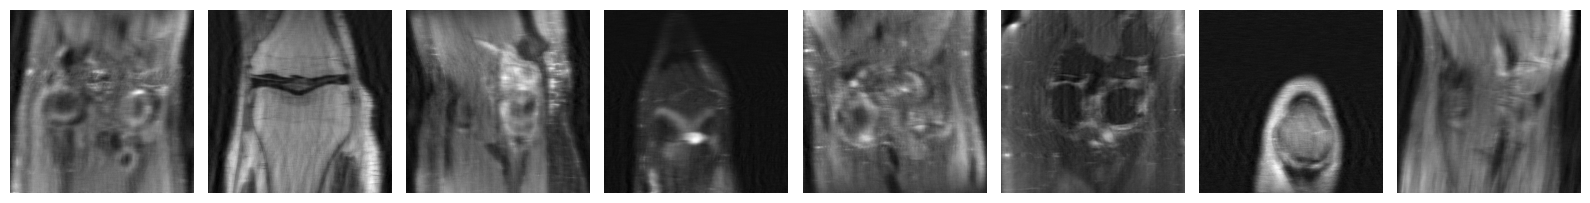

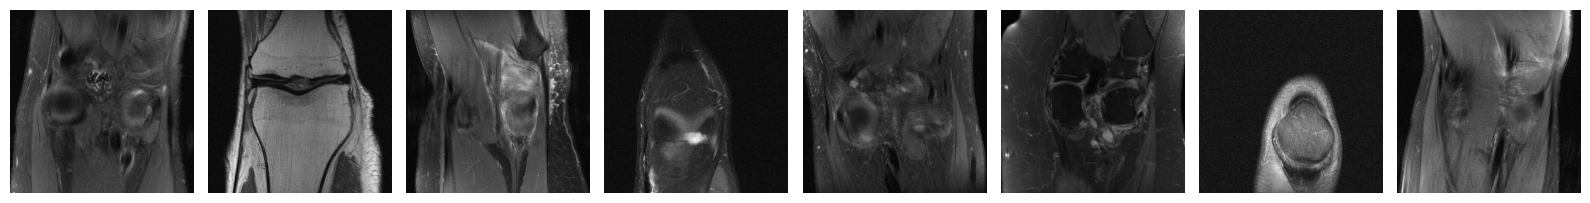

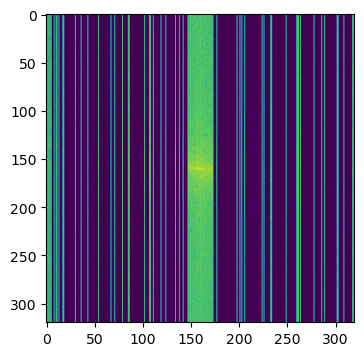

In [ ]:
from matplotlib import pyplot as plt

def plot_images(batch_images):
    n = batch_images.shape[0] # batch,row,col
    
    fig, axes = plt.subplots(1, n, figsize=(2 * n, 4))  # Single row, n columns
    
    for i in range(n):
        axes[i].imshow(batch_images[i], cmap='gray' if batch_images[i].ndim == 2 else None)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

dirty, target, mean, std, _, fname, slice, max_val, mask, masked_kspace = train_data
dirty = Tpb.complex_abs(dirty.permute(0,2,3,1)).numpy()
target = Tpb.complex_abs(target.permute(0,2,3,1)).numpy()
print(target.shape)
masked_kspace = masked_kspace.permute(0,2,3,1) 
masked_kspace0 = masked_kspace[0]
masked_kspace0_np = T.tensor_to_complex_np(masked_kspace0.contiguous())
masked_kspace0_log = np.log(np.abs(masked_kspace0_np) + 1e-10)

plot_images(dirty)
plot_images(target)
plt.figure(figsize=(4,4))
plt.imshow(masked_kspace0_log)


In [ ]:
from matplotlib import pyplot as plt
import sigpy.mri.app as sp
from data import transformsPB as Tpb

file_name = '/mnt/sdb/susant/Knee_Multicoil_train_batch0/multicoil_train/file1000584.h5'
hf = h5py.File(file_name)
print('Keys:', list(hf.keys()))
# print('Attrs:', dict(hf.attrs))
target = hf['reconstruction_rss'][(22)]
kspace = hf['kspace'][(22)]

image = Tpb.to_tensor(target.astype(complex))
k_space = Tpb.fft2c_new(image)
print('k space shape: ',k_space.shape)
kspace_np = T.tensor_to_complex_np(k_space)
kspace_log = np.log(np.abs(kspace_np)+1e-10)
target_rec = Tpb.complex_abs(Tpb.ifft2c_new(k_space))
target_rec_np = target_rec.numpy()

# Masked k-space
mask_type = 'random'
center_fractions = [0.08] 
accelerations = [4]
mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
masked_kspace, mask = transforms.apply_mask(k_space, mask_func, seed=False)
masked_kspace_np = T.tensor_to_complex_np(masked_kspace)
masked_kspace_log = np.log(np.abs(masked_kspace_np)+1e-10)
image_rec = Tpb.complex_abs(Tpb.ifft2c_new(masked_kspace))
image_rec_np = image_rec.numpy()

mask = mask.repeat(image.shape[1], 1, 1).squeeze().unsqueeze(0)
print(mask.shape)
mask_np = mask.squeeze(0).numpy()
plt.figure()
plt.imshow(mask_np, cmap='gray')

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(kspace_log)
plt.subplot(2,2,2)
plt.imshow(target_rec_np, cmap='gray')
plt.subplot(2,2,3)
plt.imshow(masked_kspace_log)
plt.subplot(2,2,4)
plt.imshow(image_rec_np, cmap='gray')


**ReconFormer Inference**

/tmp/ipykernel_2262788/1305465569.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location="cpu")  # Load on CPU first


Recon output Shape:  (39, 320, 320)
Acquisition: CORPDFS_FBK, Average NMSE: 0.0097
Acquisition: CORPDFS_FBK, Average PSNR: 39.6440
Acquisition: CORPDFS_FBK, Average SSIM: 0.9276


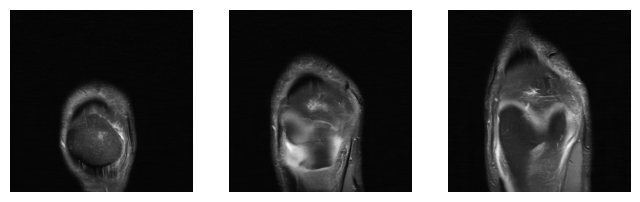

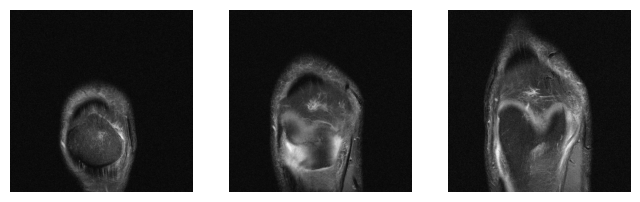

: 

In [ ]:
from typing import Optional
from collections import OrderedDict
from skimage.metrics import peak_signal_noise_ratio as psnr
from matplotlib import pyplot as plt

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(8,8))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

# Volume-wise PNR ans SSIM calculation
def vol_avg_measures(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    
    """Computes volume-wise average following measures:
    Normalized Mean Square Error (NMSE),
     Peak Signal to Noise Ratio (PSNR), Structural Similarity Index Metric (SSIM)"""
    
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")
    
    maxval = gt.max() if maxval is None else maxval

    nmse_mes = np.array([0])
    ssim_mes = np.array([0])
    psnr_mes = np.array([0])

    for slice_num in range(gt.shape[0]):
        
        nmse_mes = nmse_mes + nmse(
            gt[slice_num], pred[slice_num]
        )
        
        psnr_mes = psnr_mes + psnr(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

        ssim_mes = ssim_mes + ssim(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return nmse_mes / gt.shape[0], psnr_mes / gt.shape[0], ssim_mes / gt.shape[0]

def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2) 


# Load model
# model_path = "/home/susant/ReconFormer_MRI_recon/ReconFormer_savedModels/Acc8_EncDec_Iter4_l1Loss/ReconFormer_Acc8_best.pth"
model_path = "path_to/ReconFormer_Acc8_best.pth"
model = ReconFormer_EDR(in_channels=2, out_channels=2, num_ch=(96, 48, 24), num_iter=4,
                         down_scales=(2, 1, 1.5), img_size=320, num_heads=(6, 6, 6), depths=(2, 1, 1),
                         window_sizes=(8, 8, 8), mlp_ratio=2.0, resi_connection='1conv',
                         use_checkpoint=(False, False, True, True, False, False)).to(device)
# Load the trained model checkpoint
checkpoint = torch.load(model_path, map_location="cpu")  # Load on CPU first

# Fix DataParallel issue
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    new_key = k.replace("module.", "")  # Remove 'module.' prefix from keys
    new_state_dict[new_key] = v

# Load state dict
model.load_state_dict(new_state_dict)

model.to(device)
model.eval()

# Load test data
input_file = "/storage/FastMRI/Knee/knee_multicoil_val_subset/file1002389.h5"
with h5py.File(input_file, 'r') as h5test:
    target = np.array(h5test['reconstruction_rss'], dtype=np.float32)
    maxval = h5test.attrs['max']
    acquisition = h5test.attrs['acquisition']

num_slices = target.shape[0]
gt_imgs, recon_imgs = [], []


for i in range(num_slices):
    mask_type = 'random'
    center_fractions = [0.04] 
    accelerations = [8]
    
    # Apply mask
    mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

    #######################
    gt_tensor = Tpb.to_tensor(target[i].astype(complex)) # (Height x Width x 2)
    gt_tensor = T.complex_center_crop(gt_tensor, (320,320))
    kspace = Tpb.fft2c_new(gt_tensor)                 # (Height x Width x 2)
        
    # Apply mask
    masked_kspace, mask = transforms.apply_mask(kspace, mask_func, seed=True)
    image = Tpb.ifft2c_new(masked_kspace) # (Height, Width, 2)

    # Absolute value
    abs_image = Tpb.complex_abs(image) # (height, width)
    mean = torch.tensor(0.0)
    std = abs_image.mean()
    # Normalize input
    image = image.permute(2, 0, 1)    # (2 x Height x Width)
    gt_tensor = gt_tensor.permute(2, 0, 1)  # (2 x Height x Width)
    image = transforms.normalize(image, mean, std, eps=1e-10)
    masked_kspace = masked_kspace.permute(2, 0, 1)  # (2 x Height x Width)
    masked_kspace = transforms.normalize(masked_kspace, mean, std, eps=1e-10)
    # Normalize target
    gt_tensor = transforms.normalize(gt_tensor, mean, std, eps=1e-10)
    mask = mask.repeat(image.shape[1], 1, 1).squeeze().unsqueeze(0) 
    ######################
    target1 = T.center_crop(target[i], (320,320))
    gt_imgs.append(target1)
    
    # Model inference
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device).float(), masked_kspace.unsqueeze(0).to(device).float(), mask.unsqueeze(0).to(device))
    
    output = output.squeeze(0).permute(2,1,0)
    output = output*std + mean
    output_np = np.transpose(Tpb.complex_abs(output).squeeze().cpu().numpy(), axes=None)
    recon_imgs.append(output_np)

# Convert lists to NumPy arrays
gt_imgs_np = np.asarray(gt_imgs, dtype=np.float32)
recon_imgs_np = np.asarray(recon_imgs, dtype=np.float32)
print('Recon output Shape: ', recon_imgs_np.shape)
np.save('RecFormEDR_GradL1_Acc8_2389', recon_imgs_np)
# Compute quantitative metrics
avg_nmse, avg_psnr, avg_ssim = vol_avg_measures(gt_imgs_np, recon_imgs_np, maxval)

print(f'Acquisition: {acquisition}, Average NMSE: {avg_nmse.item():.4f}')
print(f'Acquisition: {acquisition}, Average PSNR: {avg_psnr.item():.4f}')
print(f'Acquisition: {acquisition}, Average SSIM: {avg_ssim.item():.4f}')

# Display reconstructed and ground truth slices
show_slices(recon_imgs_np, [6, 10, 13], cmap='gray')
show_slices(gt_imgs_np, [6, 10, 13], cmap='gray')

**Folder Inference**

In [10]:
import os
import h5py
import numpy as np
import torch
import time
from collections import OrderedDict
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def vol_avg_measures(gt: np.ndarray, pred: np.ndarray, maxval: float) -> tuple:
    if gt.ndim != 3 or pred.ndim != 3:
        raise ValueError("Ground truth and prediction must have 3 dimensions (slices, height, width).")
    
    nmse_vals, psnr_vals, ssim_vals = [], [], []
    for slice_num in range(gt.shape[0]):
        nmse_vals.append(nmse(gt[slice_num], pred[slice_num]))
        psnr_vals.append(psnr(gt[slice_num], pred[slice_num], data_range=maxval))
        ssim_vals.append(ssim(gt[slice_num], pred[slice_num], data_range=maxval))
    
    return np.mean(nmse_vals), np.mean(psnr_vals), np.mean(ssim_vals)

def nmse(gt: np.ndarray, pred: np.ndarray) -> float:
    return np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2

# Load model
model_path = "/home/susant/ReconFormer_MRI_recon/ReconFormer_savedModels/Acc4_EDR_Iter4_25PerL1/ReconFormer_Acc4_best.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ReconFormer(in_channels=2, out_channels=2, num_ch=(96, 48, 24), num_iter=4,
                     down_scales=(2, 1, 1.5), img_size=320, num_heads=(6, 6, 6), depths=(2, 1, 1),
                     window_sizes=(8, 8, 8), mlp_ratio=2.0, resi_connection='1conv',
                     use_checkpoint=(False, False, True, True, False, False)).to(device)
checkpoint = torch.load(model_path, map_location=device)
new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in checkpoint.items())
model.load_state_dict(new_state_dict)
model.eval()

# Initialize storage
corpd_metrics = []
corpdfs_metrics = []

folder_path = "/storage/FastMRI/Knee/knee_multicoil_val_subset"
for file_name in os.listdir(folder_path):
    if file_name.endswith(".h5"):
        file_path = os.path.join(folder_path, file_name)
        with h5py.File(file_path, 'r') as h5test:
            target = np.array(h5test['reconstruction_rss'], dtype=np.float32)
            maxval = h5test.attrs['max']
            acquisition = h5test.attrs['acquisition']

        num_slices = target.shape[0]
        gt_imgs, recon_imgs, slice_times = [], [], []

        for i in range(num_slices):
            # Masking and transformation logic
            mask_type = 'random'
            center_fractions = [0.08]
            accelerations = [4]
            mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

            gt_tensor = Tpb.to_tensor(target[i].astype(complex))
            kspace = Tpb.fft2c_new(gt_tensor)
            masked_kspace, mask = transforms.apply_mask(kspace, mask_func, seed=True)
            image = Tpb.ifft2c_new(masked_kspace)
            abs_image = Tpb.complex_abs(image)
            mean, std = torch.tensor(0.0), abs_image.mean()
            image = transforms.normalize(image.permute(2, 0, 1), mean, std, eps=1e-10)
            masked_kspace = transforms.normalize(masked_kspace.permute(2, 0, 1), mean, std, eps=1e-10)
            gt_tensor = transforms.normalize(gt_tensor.permute(2, 0, 1), mean, std, eps=1e-10)
            mask = mask.repeat(image.shape[1], 1, 1).squeeze().unsqueeze(0)

            gt_imgs.append(target[i])
            
            with torch.no_grad():
                start_time = time.time()
                output = model(image.unsqueeze(0).to(device).float(),
                               masked_kspace.unsqueeze(0).to(device).float(),
                               mask.unsqueeze(0).to(device))
                end_time = time.time()
            
            slice_times.append(end_time - start_time)

            output = output.squeeze(0).permute(2, 1, 0)
            output = output * std + mean
            output_np = np.transpose(Tpb.complex_abs(output).squeeze().cpu().numpy(), axes=None)
            recon_imgs.append(output_np)
        
        gt_imgs_np = np.asarray(gt_imgs, dtype=np.float32)
        recon_imgs_np = np.asarray(recon_imgs, dtype=np.float32)
        avg_nmse, avg_psnr, avg_ssim = vol_avg_measures(gt_imgs_np, recon_imgs_np, maxval)

        mean_time = round(np.mean(slice_times), 4)
        std_time = round(np.std(slice_times), 4)

        metrics_tuple = (file_name, avg_nmse, avg_psnr, avg_ssim, mean_time, std_time)

        if acquisition == "CORPD_FBK":
            corpd_metrics.append(metrics_tuple)
        elif acquisition == "CORPDFS_FBK":
            corpdfs_metrics.append(metrics_tuple)

# Print results
print("CORPD Measures:")
for item in corpd_metrics:
    print(item)

print("\nCORPDFS Measures:")
for item in corpdfs_metrics:
    print(item)


/tmp/ipykernel_2554261/4216100099.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


CORPD Measures:
('file1000660.h5', 0.002645930683131918, 41.96763411280857, 0.9668064024029459, 0.1594, 0.0309)
('file1000464.h5', 0.0010753027553481636, 41.72740258115343, 0.9662843744265689, 0.155, 0.0225)
('file1002021.h5', 0.0021172584800321793, 43.80424902247865, 0.9754411335383065, 0.1615, 0.0283)
('file1001064.h5', 0.002514135553869965, 46.114642739001454, 0.9819208121860866, 0.16, 0.0289)
('file1000283.h5', 0.0030507211478192557, 39.99529820249564, 0.9462367079462252, 0.1626, 0.0216)
('file1001893.h5', 0.0019119667021268, 41.65366978490216, 0.963339002018289, 0.1641, 0.0245)
('file1000350.h5', 0.0011993726421046114, 42.44953106494472, 0.9659696484727109, 0.1627, 0.0276)
('file1000153.h5', 0.0029933188494097084, 38.59969113867235, 0.9358196160483444, 0.1632, 0.0253)
('file1001687.h5', 0.0032946954232051656, 44.588557467899705, 0.9741732395602629, 0.155, 0.0248)
('file1001170.h5', 0.0022396109624888004, 41.61619174881198, 0.9658426888521993, 0.159, 0.0263)
('file1000537.h5', 0.00

In [ ]:
# Write to a CSV file
# Save items to a CSV file
import csv
with open("ReconFormerEDR_corpd_25Acc4.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(corpd_metrics)  # Write all rows at once

print("Items saved to output.csv.")

Items saved to output.csv.


: 

**Folder Inference (Brain)**

In [ ]:
import os
import h5py
import numpy as np
import torch
import time
from collections import OrderedDict
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def vol_avg_measures(gt: np.ndarray, pred: np.ndarray, maxval: float) -> tuple:
    if gt.ndim != 3 or pred.ndim != 3:
        raise ValueError("Ground truth and prediction must have 3 dimensions (slices, height, width).")
    
    nmse_vals, psnr_vals, ssim_vals = [], [], []
    for slice_num in range(gt.shape[0]):
        nmse_vals.append(nmse(gt[slice_num], pred[slice_num]))
        psnr_vals.append(psnr(gt[slice_num], pred[slice_num], data_range=maxval))
        ssim_vals.append(ssim(gt[slice_num], pred[slice_num], data_range=maxval))
    
    return np.mean(nmse_vals), np.mean(psnr_vals), np.mean(ssim_vals)

def nmse(gt: np.ndarray, pred: np.ndarray) -> float:
    return np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2

# Load model
# model_path = "/home/susant/ReconFormer_MRI_recon/ReconFormer_savedModels/Acc8_EncDec_Iter4_GradL1/ReconFormer_Acc8_best.pth"
model_path = "path_to/ReconFormer_Acc8_best.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ReconFormer_EDR(in_channels=2, out_channels=2, num_ch=(96, 48, 24), num_iter=4,
                     down_scales=(2, 1, 1.5), img_size=320, num_heads=(6, 6, 6), depths=(2, 1, 1),
                     window_sizes=(8, 8, 8), mlp_ratio=2.0, resi_connection='1conv',
                     use_checkpoint=(False, False, True, True, False, False)).to(device)
checkpoint = torch.load(model_path, map_location=device)
new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in checkpoint.items())
model.load_state_dict(new_state_dict)
model.eval()

# Initialize storage
brain_metrics = []

folder_path = "/storage/FastMRI/Brain/Multicoil_Train0_subset"
for file_name in os.listdir(folder_path):
    if file_name.endswith(".h5"):
        file_path = os.path.join(folder_path, file_name)
        with h5py.File(file_path, 'r') as h5test:
            target = np.array(h5test['reconstruction_rss'], dtype=np.float32)
            maxval = h5test.attrs['max']

        # Skip the volume if any slice is smaller than 320x320
        slice_h, slice_w = target.shape[1:3]
        if slice_h < 320 or slice_w < 320:
            print(f"Skipping volume {file_name} with slice shape ({slice_h}, {slice_w})")
            continue  # Skip this volume entirely

        num_slices = target.shape[0]
        gt_imgs, recon_imgs, slice_times = [], [], []

        for i in range(num_slices):
            # Masking and transformation logic
            mask_type = 'random'
            center_fractions = [0.04]
            accelerations = [8]
            mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)

            target_i = T.center_crop(target[i], (320, 320))
            gt_tensor = Tpb.to_tensor(target_i.astype(complex))
            kspace = Tpb.fft2c_new(gt_tensor)
            masked_kspace, mask = transforms.apply_mask(kspace, mask_func, seed=True)
            image = Tpb.ifft2c_new(masked_kspace)
            abs_image = Tpb.complex_abs(image)
            mean, std = torch.tensor(0.0), abs_image.mean()
            image = transforms.normalize(image.permute(2, 0, 1), mean, std, eps=1e-10)
            masked_kspace = transforms.normalize(masked_kspace.permute(2, 0, 1), mean, std, eps=1e-10)
            gt_tensor = transforms.normalize(gt_tensor.permute(2, 0, 1), mean, std, eps=1e-10)
            mask = mask.repeat(image.shape[1], 1, 1).squeeze().unsqueeze(0)

            gt_imgs.append(T.center_crop(target[i], (320, 320)))

            with torch.no_grad():
                start_time = time.time()
                output = model(image.unsqueeze(0).to(device).float(),
                               masked_kspace.unsqueeze(0).to(device).float(),
                               mask.unsqueeze(0).to(device))
                end_time = time.time()

            slice_times.append(end_time - start_time)

            output = output.squeeze(0).permute(2, 1, 0)
            output = output * std + mean
            output_np = np.transpose(Tpb.complex_abs(output).squeeze().cpu().numpy(), axes=None)
            recon_imgs.append(output_np)

        gt_imgs_np = np.asarray(gt_imgs, dtype=np.float32)
        recon_imgs_np = np.asarray(recon_imgs, dtype=np.float32)
        avg_nmse, avg_psnr, avg_ssim = vol_avg_measures(gt_imgs_np, recon_imgs_np, maxval)

        mean_time = round(np.mean(slice_times), 4)
        std_time = round(np.std(slice_times), 4)

        metrics_tuple = (file_name, avg_nmse, avg_psnr, avg_ssim, mean_time, std_time)
        brain_metrics.append(metrics_tuple)


# Print results
print("Brain Performance Measures:")
for item in brain_metrics:
    print(item)

/tmp/ipykernel_1310548/4213698390.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Skipping volume file_brain_AXT1_202_6000305.h5 with slice shape (320, 270)
Skipping volume file_brain_AXT1_202_6000382.h5 with slice shape (320, 270)
Skipping volume file_brain_AXFLAIR_201_6002914.h5 with slice shape (320, 260)
Skipping volume file_brain_AXFLAIR_201_6002888.h5 with slice shape (320, 260)
Skipping volume file_brain_AXT1_202_6000534.h5 with slice shape (320, 270)
Skipping volume file_brain_AXT1_202_6000347.h5 with slice shape (320, 270)
Skipping volume file_brain_AXT1POST_205_2050159.h5 with slice shape (320, 260)
Brain Performance Measures:
('file_brain_AXT1_202_2020384.h5', 0.009599402515666182, 40.1107483840764, 0.9390184691670138, 0.1735, 0.1052)
('file_brain_AXT2_210_6001747.h5', 0.023982649915239705, 31.366900265897414, 0.7467940554534688, 0.1396, 0.0003)
('file_brain_AXT2_200_6002551.h5', 0.010659619927704688, 36.78721458631952, 0.9428116973935026, 0.1396, 0.0004)
('file_brain_AXT2_200_6002387.h5', 0.01210721165656295, 33.07810265926853, 0.9146866379153897, 0.1413

In [ ]:
# Write to a CSV file
# Save items to a CSV file
import csv
with open("ReconFormerEDR_brain_Acc8_I4.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(brain_metrics)  # Write all rows at once

print("Items saved to output.csv.")